In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def potential(k, x):
    return 0.5 * k * x**2

def probability(k, kT, x):
    front = (k/(2*np.pi*kT))**0.5
    return front * np.exp(-potential(k, x)/kT)

def avg_potential(k, kT):
    integrand = lambda x: potential(k, x) * probability(k, kT, x)
    return quad(integrand, -np.inf, np.inf)[0]

class MCMC:
    def __init__(self, k=1, kT=0.15, x=0, xmin=-2, xmax=2):
        self.k = k
        self._kT = kT
        self.x = x
        self.V = potential(self.k, self.x)
        self.P = probability(self.k, self._kT, self.x)
        self.V_avg = avg_potential(self.k, self.kT)
        self.xmin = xmin
        self.xmax = xmax
        self.samples = []
    
    @property
    def kT(self):
        return self._kT
    
    @kT.setter
    def kT(self, new_kT):
        print('--- Changing kT ---')
        if self._kT != new_kT:
            self.sample = None
            self._kT = new_kT
    
    def step(self, Delta=0.1):
        x1 = self.x + np.random.randn()*Delta
        P1 = probability(self.k, self._kT, x1)
        if P1/self.P > 1 or np.random.rand() < P1/self.P:
            self.x = x1
            self.P = P1
        self.samples.append(self.x)
    
    def run(self, N):
        for _ in range(N):
            self.step()
        self.V_avg_MCMC = np.sum(potential(self.k, np.array(self.samples))) / N
    
    def plot(self, ax, xwidth=0.1, show_V_avg=True, show_V_avg_MCMC=True):
        # Plot the potential
        xs = np.linspace(self.xmin, self.xmax, 100)
        ax.plot(xs, potential(self.k, xs), label='Potential')

        # Plot the probability distribution
        xs = np.arange(self.xmin, self.xmax, xwidth)
        bars, xs = np.histogram(self.samples, xs)

        xvals = 0.5*(xs[1:] + xs[:-1])
        delta_xvals = xvals[1] - xvals[0]
        P = bars / np.sum(bars) / delta_xvals
        width = delta_xvals*0.9
        ax.bar(xvals, P, width=width, label='Probability')

        # Plot the average potential
        if show_V_avg:
            ax.axhline(self.V_avg, color='tab:orange', linestyle='--', label=f'Average Potential = {self.V_avg:.2f}')

        # Plot the average potential computed from direct sampling
        if show_V_avg_MCMC:
            if self.samples == []:
                self.run(1000)
            ax.axhline(self.V_avg_MCMC, color='tab:green', linestyle='--', label=f'Average Potential (MCMC) = {self.V_avg_MCMC:.2f}')

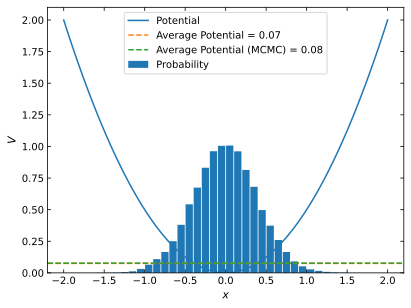

In [3]:
sampler = MCMC()
sampler.run(100000)
fig, ax = plt.subplots()
ax.set(xlabel=r'$x$', ylabel=r'$V$')
sampler.plot(ax)
ax.legend()

fig.savefig('ex8_fig1.png')